In [1]:
# Ignoring warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Imports, as always...

import pandas as pd
import numpy as np

# PyTorch (+ Geometric)
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv

# Visualisation.
import matplotlib.pyplot as plt
import seaborn as sns

# Script imports.
from scripts.training import train, evaluate
from scripts.utils import produce_reduced_embeddings, plot_reduced_embeddings
from scripts import models

In [3]:
# Beautification.
sns.set_context('paper')
sns.set_style('darkgrid')
sns.set_palette('Set2')

In [4]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Set RNG.
torch.manual_seed(42)

In [6]:
# Dataset.
from torch_geometric.datasets import Planetoid

dataset = Planetoid(
    root='./',
    name='CiteSeer',
    split='public',
    transform=torch_geometric.transforms.GCNNorm()
  )

print(dataset.data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


# Convergence

This notebook will look at the convergence property of GNN architectures using different forms of residual connections; those being: (1) **None**, (2) **fixed-weight**, (3) **freely-learnt** (or unconstrained), (4) **hierarchically-weighted**, and (5) **cluster-keeping**. We may also vary the underlying diffusion type; e.g. convolutional, attention-based, etc.

In [7]:
# Testing that out.
n_nodes = dataset.data.x.shape[0]
free_model = models.BackboneModel(
    residual_method=models.HierarchicalRC,
    aggregation_function=GCNConv,
    n_nodes=n_nodes,
    input_dim=dataset.num_features,
    hid_dim=64,
    n_classes=dataset.num_classes,
    n_layers=5,
    dropout_ratio=.1,
    act_fn=F.tanh
)

_ = train(
    free_model,
    dataset.data,
    device,
    epochs=200,
    max_patience=20,
    lr=1e-4,
    progress_bar=True,
    verbose=True
)

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 010: train loss - 1.728, train acc - 0.558, val loss - 1.763, val acc - 0.380
Epoch 020: train loss - 1.661, train acc - 0.800, val loss - 1.736, val acc - 0.530
Epoch 030: train loss - 1.586, train acc - 0.908, val loss - 1.706, val acc - 0.612
Epoch 040: train loss - 1.499, train acc - 0.942, val loss - 1.669, val acc - 0.650
Epoch 050: train loss - 1.400, train acc - 0.942, val loss - 1.626, val acc - 0.676
Epoch 060: train loss - 1.291, train acc - 0.933, val loss - 1.578, val acc - 0.684
Epoch 070: train loss - 1.175, train acc - 0.942, val loss - 1.524, val acc - 0.696
Epoch 080: train loss - 1.056, train acc - 0.950, val loss - 1.468, val acc - 0.702
Epoch 090: train loss - 0.941, train acc - 0.950, val loss - 1.412, val acc - 0.702
Epoch 100: train loss - 0.832, train acc - 0.950, val loss - 1.359, val acc - 0.698
Epoch 110: train loss - 0.733, train acc - 0.950, val loss - 1.311, val acc - 0.696
Epoch 120: train loss - 0.645, train acc - 0.950, val loss - 1.267, val acc 

In [8]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features = produce_reduced_embeddings(free_model, dataset.data, dataset.data.val_mask)

Text(0, 0.5, '')

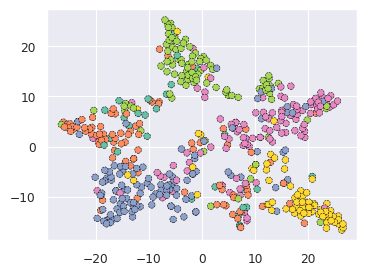

In [9]:
_, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot onto a row of axes.
sns.scatterplot(
    # Plot points and colour them.
    x=reduced_features['dimension 1'],
    y=reduced_features['dimension 2'],
    hue=reduced_features['labels'],
    ax=ax,

    # Beautification.
    palette='Set2',
    linestyle='--',
    edgecolors='k'
)

# Remove clutter.
ax.legend([], [], frameon=False)
ax.set_xlabel('')
ax.set_ylabel('')